In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np 
import PIL.Image
import time

In [3]:
content_path= "/cxldata/dlcourse/dog.jpg"
style_path= "/cxldata/dlcourse/moon.jpg"

In [4]:
"""
1.Set max_dim to 512 to set the maximum dimensions of the input image.
2.Read the image from the given path using tf.image.decode_image.
3.Convert the image pixels to float32 using tf.image.convert_image_dtype.
4.Get the maximum dimension long_dim from the shape of the input image. 
  The max_dim is divided by this long_dim to get the scale measure so that
  the scale could be used to resize the image.
5.The shape is multiplied by scale and the integer result is used along with tf.image.resize to resize the image.

  Images that are represented using floating-point values are expected to have values in the range [0,1).
  Image data stored in integer data types are expected to have values in the range [0,MAX], where MAX is the largest positive representable number for the data type."""
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)#reads the entire contents of the input filename.It returns a Tensor of type string which contains bit-representations of the image
    img = tf.image.decode_image(img, channels=3)#detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert the input bytes 
                                                #string into a Tensor of type uint8. For uint8, the minimum value is 0 and the maximum value is 255.
    img = tf.image.convert_image_dtype(img, tf.float32)#converts the image tensor values to the specified dtype, scaling its values if needed.
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)#converts all the dimensions - except the last dimension - of the img to float32 data type.
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)#resizes image to a specified size.
    img = img[tf.newaxis, :]#increase the dimension of the existing array by one more dimension.
    return img
content_image= load_img(content_path)
style_image= load_img(style_path)

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

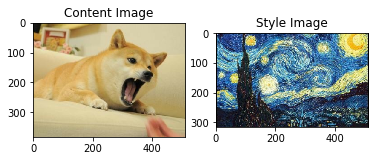

In [6]:
plt.subplot(1,2,1)
imshow(content_image,"Content Image")
plt.subplot(1,2,2)
imshow(style_image, 'Style Image')

In [7]:
print("Content image shape:", content_image.shape)
print("Style image shape:", style_image.shape)

Content image shape: (1, 384, 512, 3)
Style image shape: (1, 315, 512, 3)


In [8]:
#Loading pre-trained VGG19
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)#returns the images converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
x = tf.image.resize(x, (224, 224))#When setting include_top=True and loading imagenet weights, input_shape should be (224, 224, 3)
vgg = tf.keras.applications.VGG19(include_top = True, weights='imagenet')#  set include_top=True, since we want to cross-check if the network is able to correctly predict our content_image
prediction_probabilities = vgg(x)
print(prediction_probabilities.shape)#VGG19 on the Imagenet database is trained to classify 1000 classes.


(1, 1000)


In [9]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions( prediction_probabilities.numpy() )[0]

print([(class_name, prob) for (number, class_name, prob) in predicted_top_5])

[('dingo', 0.20264639), ('Pembroke', 0.17174084), ('basenji', 0.114593424), ('Labrador_retriever', 0.047086824), ('chow', 0.036214225)]


In [10]:
#List of all layers name
vgg = tf.keras.applications.VGG19(include_top= False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
#choosing intermediate layers from the network to represent the style and content of the image
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        'block4_conv1', 
        'block5_conv1']

In [12]:
def vgg_layers(layer_names):

    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    #set include_top=False, as this is not a classification problem, but we just want to use the network as a feature extractor to extract the content and the style.
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)#get weights of that layer
    return model

In [13]:
style_extractor = vgg_layers(style_layers)

In [14]:
style_outputs = style_outputs = style_extractor(style_image*255)

In [15]:
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 315, 512, 64)
  min:  0.0
  max:  804.6958
  mean:  29.622654

block2_conv1
  shape:  (1, 157, 256, 128)
  min:  0.0
  max:  3484.2507
  mean:  185.36594

block3_conv1
  shape:  (1, 78, 128, 256)
  min:  0.0
  max:  6815.1836
  mean:  172.339

block4_conv1
  shape:  (1, 39, 64, 512)
  min:  0.0
  max:  16559.87
  mean:  639.3219

block5_conv1
  shape:  (1, 19, 32, 512)
  min:  0.0
  max:  2767.9988
  mean:  50.856007



In [16]:
#The content of an image is represented by the values of the intermediate feature maps
# the style of an image can be described by the means and correlations across the different feature maps called Gram matrix
def gram_matrix(input_tensor):

    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

    return result/(num_locations)

In [17]:
class StyleContentModel(tf.keras.models.Model):

    def __init__(self, style_layers, content_layers):
        super().__init__()#parent class
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False#set the trainable to False, as we want to use the same VGG19 weights trained on ImageNet Database.

    def call(self, inputs):# the gram-matrices representing the style of the image and, the content of the image will be returned
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                              outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output)  
                            for style_output in style_outputs]
        content_dict = {content_name:value 
            for content_name, value 
            in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value
          for style_name, value
          in zip(self.style_layers, style_outputs)}    
        return {'content':content_dict, 'style':style_dict}

In [20]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))#creates a constant tensor from a tensor-like object

In [22]:
for name, output in sorted( results['style'].items()):
    print(" ", name)
    print("  shape: ", output.numpy().shape)
    print("  min:", output.numpy().min())
    print("  max:", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

  block1_conv1
  shape:  (1, 64, 64)
  min: 0.0009752748
  max: 38465.145
  mean:  223.63496

  block2_conv1
  shape:  (1, 128, 128)
  min: 0.0
  max: 41885.984
  mean:  5817.8

  block3_conv1
  shape:  (1, 256, 256)
  min: 0.0
  max: 177181.86
  mean:  5327.621

  block4_conv1
  shape:  (1, 512, 512)
  min: 0.0
  max: 1249220.6
  mean:  90560.234

  block5_conv1
  shape:  (1, 512, 512)
  min: 0.0
  max: 37045.61
  mean:  915.18506



In [23]:
for name, output in sorted (results['content'].items()):
    print(" ", name)
    print(" shape:", output.numpy().shape)
    print(" min:", output.numpy().min())
    print(" max:", output.numpy().max())
    print(" mean:", output.numpy().mean())
    

  block5_conv2
 shape: (1, 24, 32, 512)
 min: 0.0
 max: 1372.2462
 mean: 11.231072


In [32]:
#Gettign the target content
content_targets = extractor(content_image)['content']
style_targets = extractor(style_image)['style']

In [39]:
#defining hyperparameter
style_weight = 1e-2
content_weight = 1e-4
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


In [40]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=0.1)


In [41]:
image = tf.Variable(content_image)

In [48]:
#Defining loss function
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean(
                                (style_outputs[name] - style_targets[name])**2) 
                                for name in style_outputs.keys()] )
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean(
                                (content_outputs[name]-content_targets[name])**2) 
                                 for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [53]:
#Converting tensor to image
def tensor_to_image(tensor):
    tensor = tensor*255#Make the pixel values from [0 , 1] to [0, 255]
    tensor = np.array(tensor, dtype=np.uint8)#Convert the pixels from float type to int type.
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)#convert the tensor to image

In [57]:
#defining the training step
@tf.function()
#@tf.function converts a Python function to its graph representation for Faster execution, especially if the function consists of many small ops
def train_step(image):#calculation of gradient and updation of image pixel values for each train step epoch.
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

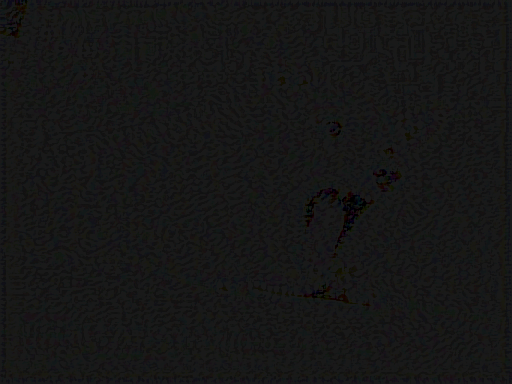

In [58]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

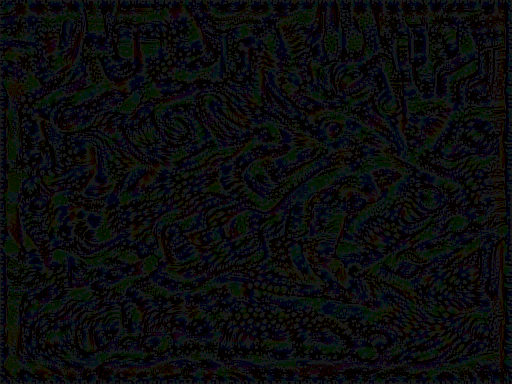

Train step: 50
Total time: 148.2


In [61]:
#Optimization
import time
start = time.time()#eturns the time as a floating-point number expressed in seconds since the epoch, in UTC.

epochs = 5
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

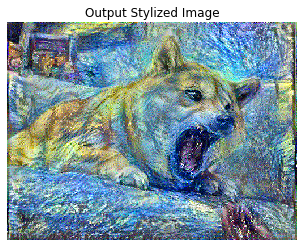

In [63]:
stylized_image = load_img("/cxldata/dlcourse/output-stylized-image.png")
plt.figure(figsize=(6,4))
plt.axis('off')
imshow(stylized_image, 'Output Stylized Image')